In [36]:
import h5py
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import deepdish as dd
from astropy import units as u
import astropy.coordinates as coord

In [2]:
from matplotlib import rc, rcParams
rc_params = {'axes.labelsize': 20,
             'axes.titlesize': 20,
             'axes.linewidth':2,
             'font.size': 20,
             'lines.linewidth' : 2.5,
             'legend.fontsize': 15,
             'xtick.labelsize': 20,
             'ytick.labelsize': 20
            }
rcParams.update(rc_params)

In [19]:
def reading_shape_data(file_data, params, shear_flag="unsheared", start=0, end=1000000):
    """
    file_data: open file data to the shape catalog
    params:   name of the parameters to be read
    shear_flag: `unsheared` or `sheared_1m`, `sheared_1p`, `sheared_2p`, `sheared_2m` (default is sheared)
    start:    index to start from (int)
    end:      index to end at (int)
    """
    data = {}
    for param_key in params:
        data[param_key] = file_data["catalog"][shear_flag][param_key][start:end]
        
    return pd.DataFrame(data)
    
def reading_DNF_redshift(file_data, params, shear_flag="unsheared", start=0, end=1000000):
    """
    file_data: open file data to the shape catalog
    params:   name of the parameters to be read
    shear_flag: `unsheared` or `sheared_1m`, `sheared_1p`, `sheared_2p`, `sheared_2m` (default is sheared)
    start:    index to start from (int)
    end:      index to end at (int)
    """
    data = {}
    for param_key in params:
        data[param_key] = file_data["catalog"][shear_flag][param_key][start:end]
        
    return pd.DataFrame(data)

In [56]:
def reading_data(shape_params, redshift_params, start, end):
    """
    shape_params: list of parameter keys for shape catalog
    redshift_params: list of redshift parameters of the sources
    start:
    end: 
    """
    
    data1 = reading_shape_data(file_data=shape_file_data, params=shape_params, start=start, end=end)
    data2 = reading_shape_data(file_data=redshift_file_data, params=redshift_params, start=start, end=end)
    data1["zmc_sof"] = data2["zmc_sof"]
    data1["zmean_sof"] = data2["zmean_sof"]
    
    # Metacal selection
    data = data1
    flags = 0
    snr_th_lower = 10
    snr_th_upper = 1000
    size_ratio = 0.5
    T = 10

    idx = np.array(data["flags"] == flags) & np.array(data["snr"] > snr_th_lower) & \
                    np.array(data["snr"] < snr_th_upper) & np.array(data["size_ratio"] > size_ratio) & \
                    np.array(data["T"] < T)
    
    data_selected = dict()
    for key in list(data.keys()):
        data_selected[key] = data[key].values[idx]
        
    return data_selected

In [32]:
# The parameters needed to computing differential surface density
params1 = ['coadd_object_id', 'ra', 'dec', 'e_1', 'e_2',\
            'snr', 'weight', 'flags', 'size_ratio', 'T',\
            'R11', 'R12', 'R21', 'R22']
params2 = ['coadd_object_id', 'zmc_sof', 'zmean_sof']

In [33]:
file = "/home/idies/workspace/Temporary/surhudm/scratch/DES/DESY3_metacal_v03-004.h5"
file_z = "/home/idies/workspace/Temporary/surhudm/scratch/DES/DESY3_GOLD_2_2.1_DNF.h5"
shape_file_data = h5py.File(file, "r")
redshift_file_data = h5py.File(file_z, "r")

In [50]:
t0 = time.time()
Nsize = data["catalog"]["unsheared"]["e_1"].shape[0]
chunksize = 10000000
for ii in range(0, Nsize//chunksize + 1):
    start = ii*chunksize
    end = (ii+1)*chunksize
    data_selected = reading_data(shape_params=params1, redshift_params=params2, start=start, end=end) 
    break
tf = time.time()
print("Time taken: %f seconds!"%(tf-t0))

Time taken: 8.118825 seconds!


In [51]:
data_selected

{'coadd_object_id': array([333409903, 333409662, 333409498, ..., 271674746, 271674034,
        271674709]),
 'ra': array([45.00143657, 44.99728215, 45.00296337, ..., 11.22955287,
        11.23316079, 11.21932604]),
 'dec': array([ 3.70687739e-03,  1.04519194e-02,  1.56680017e-02, ...,
        -2.08734328e+01, -2.08688220e+01, -2.08728184e+01]),
 'e_1': array([ 0.49758885,  0.1619972 , -0.33943113, ...,  0.38223408,
        -0.05246812, -0.43530219]),
 'e_2': array([-0.46418295,  0.0837993 ,  0.51807028, ..., -0.08719109,
         0.00283151,  0.21486723]),
 'snr': array([ 24.92721718,  32.97813787,  20.73546637, ...,  17.80135625,
        479.10434937,  23.83384899]),
 'weight': array([35.10233195, 50.7918021 , 30.65967688, ..., 24.99183152,
        48.1296227 , 31.09206975]),
 'flags': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'size_ratio': array([1.415153  , 2.73476535, 1.17707514, ..., 0.85780295, 2.31604665,
        0.86682357]),
 'T': array([0.54702584, 1.05471941, 0.45944809,

Text(0, 0.5, 'DEC [degrees]')

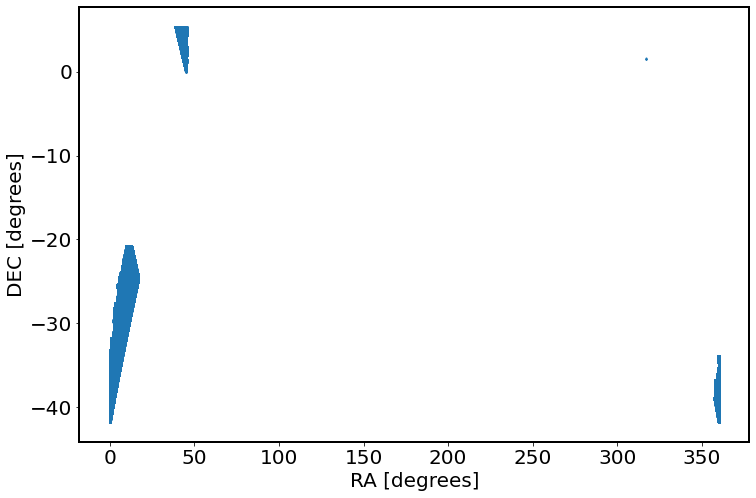

In [53]:
plt.figure(figsize=(12, 8))
plt.scatter(data_selected["ra"], data_selected["dec"], s=1)
#plt.xlim(0, 50)
plt.xlabel(r"RA [degrees]")
plt.ylabel(r"DEC [degrees]")

In [54]:
ra = coord.Angle(data_selected['ra']*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(data_selected['dec']*u.degree)

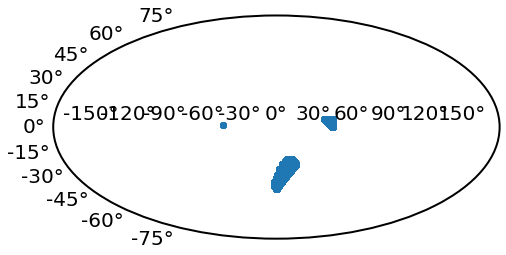

In [55]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra.radian, dec.radian)

### Parameters Required for surface density

Shear compoenents:$\gamma_1, \gamma_2$

Position angle of the galaxy with respect to halo center: $\phi$

Source and lens redshifts: $z_l, z_s$

Galaxy locations: $\alpha, \delta$

Shear and selection response: $\mathcal{R}, \mathcal{R}_s$

Squared inverse of the measured shear uncertainty: $$